Periodic DMRG example
-----------

Here we demonstrate 2-site periodic DMRG for the spin-1/2 Heisenberg model.

In [1]:
from quimb import *
from quimb.tensor import *

In [2]:
H = MPO_ham_heis(300, cyclic=True)

``quimb`` has the function ``heisenberg_energy`` which can calculate the analytic energy we are looking for:

In [3]:
heisenberg_energy(300)

-132.94690126514288

Let's create the core DMRG object that handles all the algorithm:

In [4]:
dmrg = DMRG2(H)

`DMRG2` internally forms the needed energy and norm overlaps, reusing views of the same data. We can graph, for example, the full energy expectation:

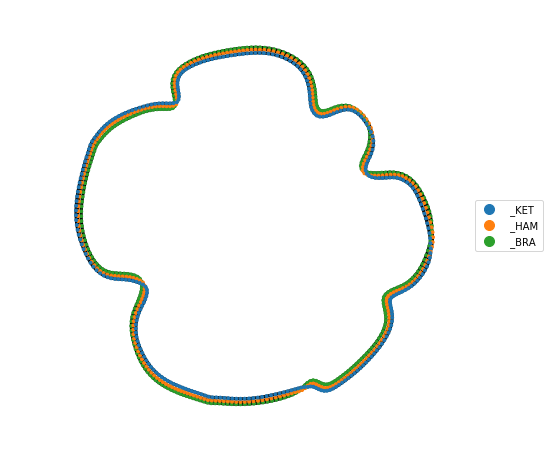

In [5]:
%matplotlib inline
dmrg.TN_energy.graph(color=['_KET', '_HAM', '_BRA'])  # might be slow as uses force repulsion

The default algorithm settings are reasonable enough to get started with:

In [6]:
dmrg.solve(max_sweeps=4, verbosity=1)

SWEEP-1, direction=R, max_bond=8, cutoff:1e-08


100%|█████████████████████████████████████████| 300/300 [00:10<00:00, 29.65it/s]

Energy: -132.2557988091905 ... not converged.
SWEEP-2, direction=R, max_bond=16, cutoff:1e-08



100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 57.44it/s]

Energy: -132.86883838252373 ... not converged.
SWEEP-3, direction=R, max_bond=32, cutoff:1e-08



100%|█████████████████████████████████████████| 300/300 [00:13<00:00, 21.93it/s]

Energy: -132.9271470252936 ... not converged.
SWEEP-4, direction=R, max_bond=64, cutoff:1e-08



 99%|████████████████████████████████████████▌| 297/300 [02:16<00:01,  2.18it/s]/IntHD/Sync/dev/python/quimb/quimb/linalg/base_linalg.py:156: UserWarning: `eigensystem_partial` with backend 'LOBPCG' failed, trying again with scipy. Set ``fallback_to_scipy=False`` to avoid this and see the full error. 
  "the full error. ".format(bkd))
100%|█████████████████████████████████████████| 300/300 [02:19<00:00,  2.14it/s]

Energy: -132.94204117263453 ... not converged.


False

We are getting pretty close to the known energy already (closer than OBC at this length can get). The relative error is:

In [7]:
(dmrg.energy - heisenberg_energy(300)) / heisenberg_energy(300)

-3.655664375854252e-05

Note that for PBC, the algorithm splits the chain into segments, and approximates the other segments with a SVD. Thus progress appears to pause at these points. The number of singular values kept for this environment approximation is recorded in ``dmrg.bond_sizes_ham`` and ``dmrg.bond_sizes_norm``:

In [8]:
dmrg.bond_sizes_norm

[[1, 1], [1, 2], [1, 5], [5, 11]]

In [9]:
dmrg.bond_sizes_ham

[[2, 2], [2, 3], [2, 6], [6, 16]]

To progress further might require tweaking the advanced options, for example, setting tighter tolerances for some of the settings found in:

In [10]:
dmrg.opts

{'default_sweep_sequence': 'R',
 'bond_compress_method': 'svd',
 'bond_compress_cutoff_mode': 'rel',
 'bond_expand_rand_strength': 1e-06,
 'local_eig_tol': 0.001,
 'local_eig_ncv': 4,
 'local_eig_backend': None,
 'local_eig_maxiter': None,
 'local_eig_EPSType': None,
 'local_eig_ham_dense': None,
 'local_eig_norm_dense': None,
 'periodic_segment_size': 0.5,
 'periodic_compress_method': 'isvd',
 'periodic_compress_norm_eps': 1e-06,
 'periodic_compress_ham_eps': 1e-06,
 'periodic_compress_max_bond': -1,
 'periodic_nullspace_fudge_factor': 1e-12,
 'periodic_canonize_inv_tol': 1e-10,
 'periodic_orthog_tol': 1e-06}

See ``quimb.tensor.tensor_dmrg.get_default_opts`` for detailed explanations of these quantities.
One could also supply custom sequences for the maximum allowed bond dimensions (e.g. ``dmrg.solve(..., bond_dims=[70, 80, 90])``) or bond compression cutoffs (e.g. ``dmrg.solve(..., cutoffs=[1e-9, 3e-10, 1e-10])``).

The full state can be retrieved from ``dmrg.state``:

In [11]:
gs = dmrg.state
gs.max_bond()

64

We could then for example compute a compressed density matrix of 50 + 50 = 100 qubits:

In [12]:
rho_ab = gs.partial_trace_compress(range(0, 50), range(50, 100))

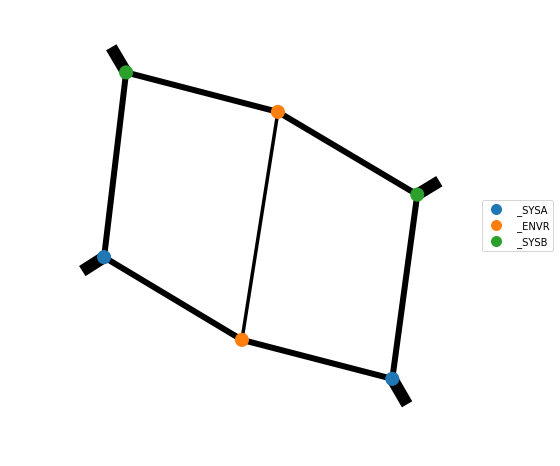

In [13]:
rho_ab.graph(color=['_SYSA', '_ENVR', '_SYSB'], show_inds=False, iterations=2000)

And check it is normalized:

In [14]:
rho_ab.outer_dims_inds()

((4096, 'kA'), (4096, 'bA'), (4096, 'kB'), (4096, 'bB'))

In [15]:
rho_ab.trace(['kA', 'kB'], ['bA', 'bB'])

1.0000000000000004